In [1]:
import numpy as np
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.util.utils import compute_returns

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Number of lags for the ACF
ACF_RANGE = 1001

# Lag/window size for Hurst
LAG = 100

## Load raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'market_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'mo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [37]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.015541
 2       0.001610
 3       0.005973
 4       0.005574
           ...   
 996    -0.001168
 997     0.000533
 998     0.001713
 999    -0.000517
 1000   -0.000748
 Length: 1001, dtype: float64)

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [38]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -320.14
p-value: 0.00,
N: 99999, 
critical values: {'1%': -3.4304153953326493, '5%': -2.8615689037124814, '10%': -2.566785384434747}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -319.31
p-value: 0.00,
N: 99999, 
critical values: {'1%': -3.4304153953326493, '5%': -2.8615689037124814, '10%': -2.566785384434747}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -322.06
p-value: 0.00,
N: 99999, 
critical values: {'1%': -3.4304153953326493, '5%': -2.8615689037124814, '10%': -2.566785384434747}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -178.95
p-value: 0.00,
N: 99997, 
critical values: {'1%': -3.4304153966406288, '5%': -2.8615689042905816, '10%': -2.5667853847424507}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 1.2. Return Autocorrelation Functions (ACFs)

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [39]:
# Save data for lazy loading
linear_filename = f"{acf_data_dir}/mo_returns_linear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [39]:
nonlinear_filename = f"{acf_data_dir}/mo_returns_nonlinear_acfs.pkl"

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

In [ ]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

### 1.3. The Long Memory of Returns?

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

#### 1.3.1. Estimate ACF scaling parameter

In [43]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 2
xmin: 3.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.17932633631685774
alpha = -0.8506021074297022

Goodness of fit to data;
D = 0.3173173173173173
bic = -11795.998415582806
mape = 202.09020998270515
Adjusted R-squared = 0.7021907284412539




#### 1.3.2. For all assets

In [44]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)

In [45]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1793263...",2,3.0,0.317317,-11795.998416,202.090210,0.702191,-0.850602,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 69633.788...",708,709.0,0.505119,-3444.428118,98.836918,-0.009686,-3.088274,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0902039...",5,6.0,0.178715,-11578.170132,36.531173,0.676817,-0.410774,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0382684...",4,5.0,0.362086,-11940.805629,215.115098,0.177259,-0.612447,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000195...",325,326.0,0.504438,-7865.429459,132.694827,-0.004464,0.000054,EBAY


In [46]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [47]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: -0.9362169100636423


In [48]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 1.4. Estimate Hurst Exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.

- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [49]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['returns'].cumsum()

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.08878075715410834
alpha = 0.508993923594669

Goodness of fit to data;
D = 0.019562715765247412
bic = -10551.073137659814
mape = 0.3039840628666917
Adjusted R-squared = 0.9998873360358319



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 28
xmin: 4.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.03435193222180402
alpha = 0.5866272248116898

Goodness of fit to data;
D = 0.010688836104513063
bic = -12636.526927697314
mape = 0.1914300187159466
Adjusted R-squared = 0.9999787658903939


Standard Hurst Exponent: 0.508993923594669 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5866272248116898 (Super-diffusive: series demonstrates persistent long-range dependence)


#### 1.4.1 For all assets

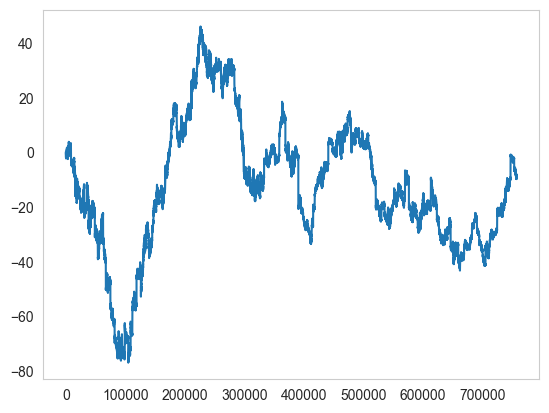

In [50]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['returns']
amzn_cum_returns = compute_returns(msft_raw_df)['returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['returns']
msft_cum_returns = compute_returns(nflx_raw_df)['returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['returns']
appl_cum_returns = compute_returns(appl_raw_df)['returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns.cumsum(),
  'MSFT': amzn_cum_returns.cumsum(),
  'AMZN': nflx_cum_returns.cumsum(),
  'NFLX': msft_cum_returns.cumsum(),
  'EBAY': ebay_cum_returns.cumsum(),
  'APPL': appl_cum_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [51]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1145656...",1,1.0,0.031746,-3040.368136,0.727560,0.999213,0.510266,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0094922...",1,1.0,0.022222,-4675.859833,0.656646,0.999255,0.495638,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2410204...",1,1.0,0.028571,-2793.443518,0.569582,0.999626,0.514030,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0417651...",1,1.0,0.022222,-3523.893856,0.993128,0.998639,0.503503,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0141333...",1,1.0,0.022222,-4738.437607,0.430865,0.999747,0.503954,EBAY,returns


In [52]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5033475963575543


In [53]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('APPL', 'standard', 'returns')])


In [54]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [55]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/po

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0428193...",1,1.0,0.012698,-4037.703129,0.570835,0.999909,0.600000,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0046053...",5,2.0,0.012862,-5558.650038,0.383467,0.999898,0.538793,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0845996...",21,7.0,0.013559,-3783.744488,0.210818,0.999967,0.589635,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0196806...",1,1.0,0.019048,-4463.209948,0.739190,0.999826,0.557226,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0038501...",1,1.0,0.012698,-5818.442651,0.383010,0.999955,0.586856,EBAY,returns


In [56]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5387928141913161
Max Generalized Hurst: 0.5999997080084587
Average Generalized Hurst: 0.5719970258010453
Standard_dev Generalized Hurst: 0.02363737149728893


In [57]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('APPL', 'generalized', 'returns')])


In [1]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
tsla_generalized_fit.powerlaw.plot_fit()

NameError: name 'fit_objects' is not defined

## 2. Percentage Returns

In [5]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### Stationarity Test

In [ ]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 2.1. Percentage returns ACF

In [9]:
# Linear ACF
percentage_returns_linear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_linear_acfs.pkl"
percentage_returns_linear_acfs = compute_acfs(filename=percentage_returns_linear_acf_filename, data=percentage_returns, option='linear')
print(percentage_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [10]:
# Nonlinear ACF
percentage_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_percentage_returns_nonlinear_acfs.pkl"
percentage_returns_nonlinear_acfs = compute_acfs(filename=percentage_returns_nonlinear_acf_filename, data=percentage_returns, option='nonlinear')
print(percentage_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


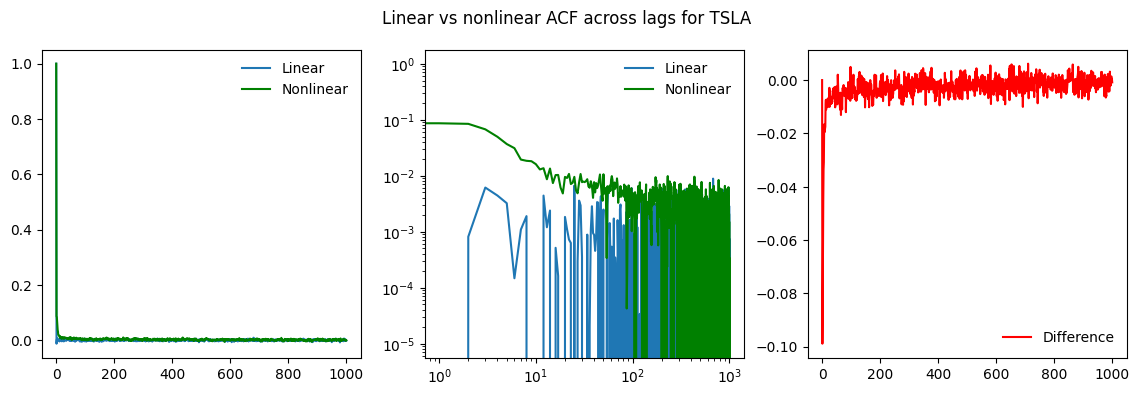

TSLA Max difference: 0.0061535779378422495


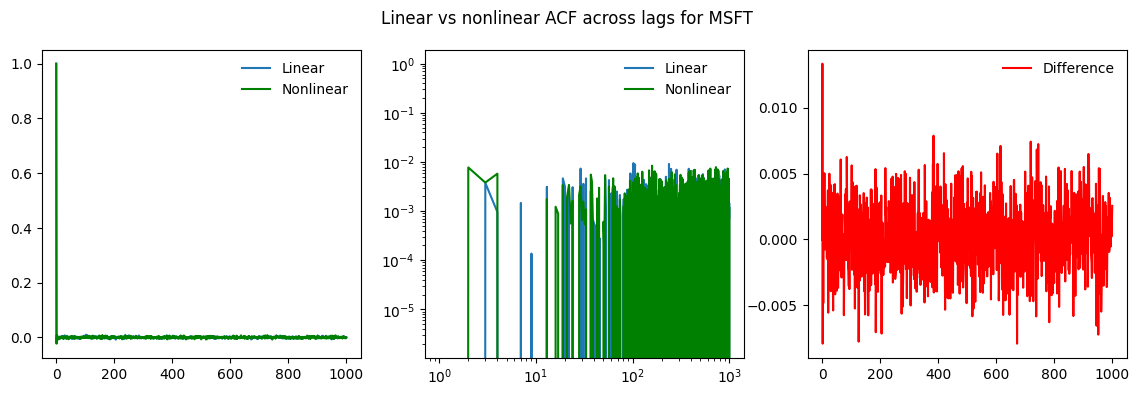

MSFT Max difference: 0.013322011882793253


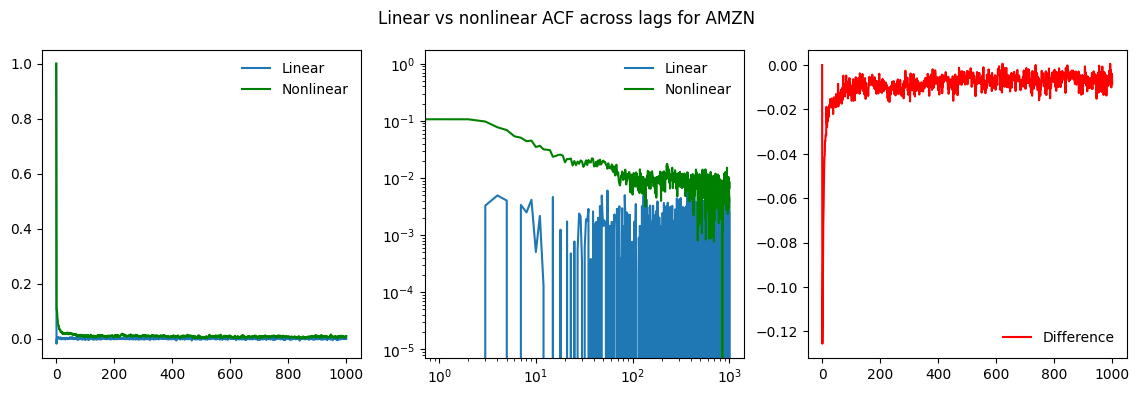

AMZN Max difference: 0.0005978766852643788


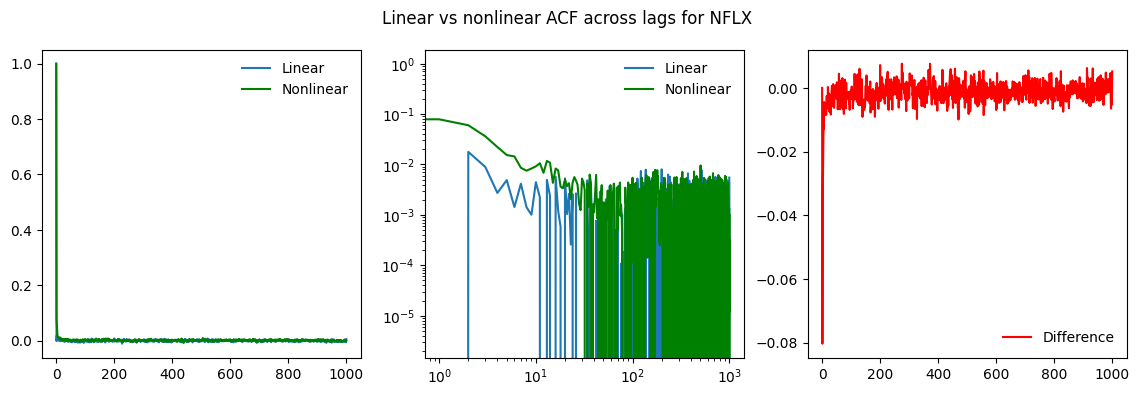

NFLX Max difference: 0.007606210118705707


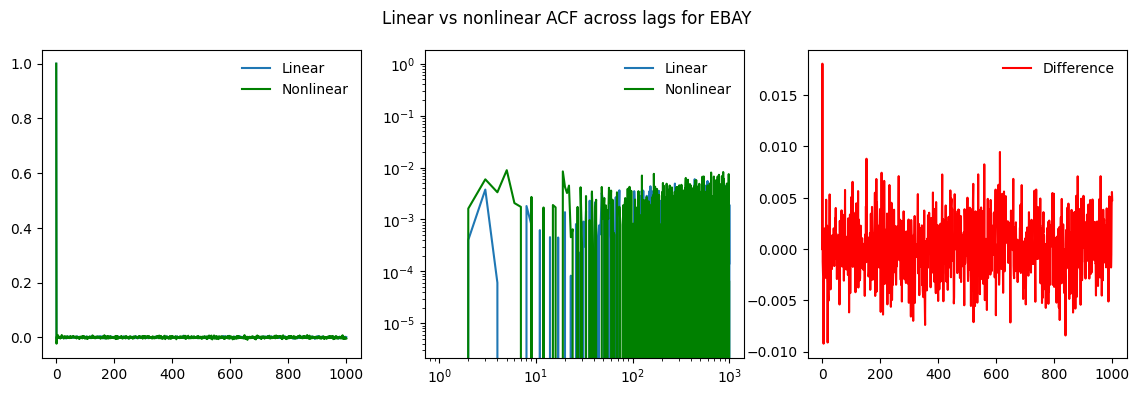

EBAY Max difference: 0.018073287636735408


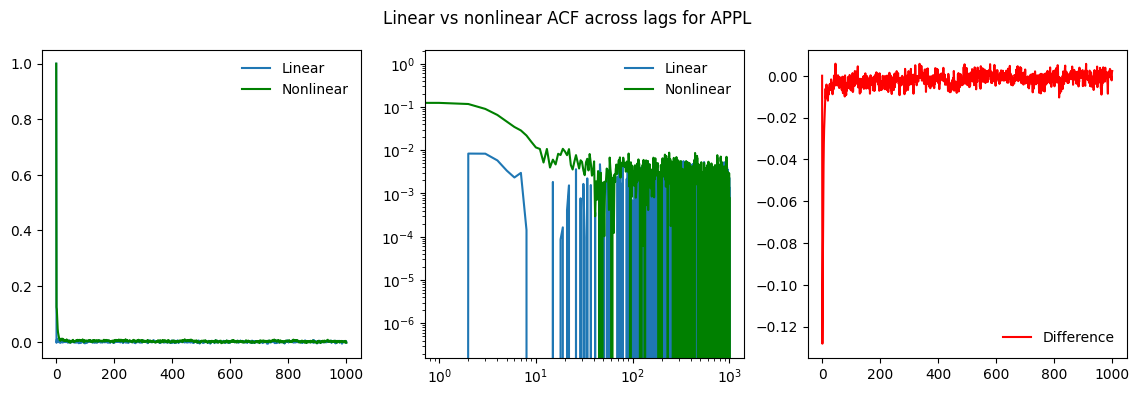

APPL Max difference: 0.005764315330237817


In [11]:
for stock_name in percentage_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, percentage_returns_linear_acfs, percentage_returns_nonlinear_acfs)

### 2.2. Fit power law to percentage returns ACF

In [12]:
# Load the pre-computed ACFs
percentage_returns_acf_values = {}

for stock, data in percentage_returns_nonlinear_acfs.items():
    percentage_returns_acf_values[stock] = construct_xy(data, stock)

In [16]:
# Using percentage_return_acf_values
percentage_returns_fit_list = []
percentage_returns_fit_objects = {}

for stock, data in percentage_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        percentage_returns_fit_list.append(fit_dict)
        percentage_returns_fit_objects[stock] = fit_obj  # Store the fit object

percentage_returns_fit_results = pd.DataFrame(percentage_returns_fit_list)
display(percentage_returns_fit_results.head())

cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1767431...",2,3.0,0.320320,-11817.442613,215.321945,0.702503,-0.848095,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -0.000190...",780,781.0,0.511312,-2589.422543,103.435632,-0.013825,0.000072,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0893171...",5,6.0,0.180723,-11581.379789,36.818743,0.673240,-0.411081,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0409273...",4,5.0,0.361083,-11984.121577,222.136738,0.180295,-0.647606,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -6.542320...",349,350.0,0.470859,-7631.342721,151.434713,-0.000979,1.969154,EBAY


In [17]:
percentage_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [18]:
avg_alpha = percentage_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.10097028507041926


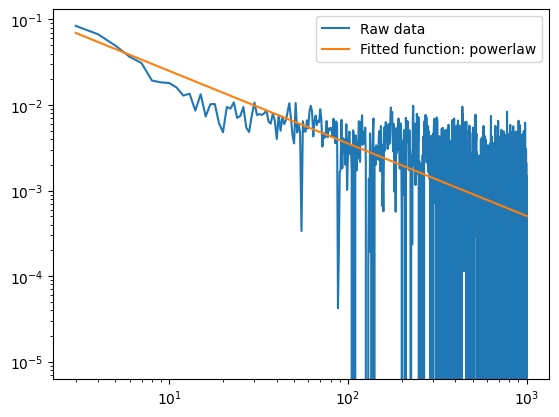

In [19]:
tsla_acf_fit = percentage_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3 Percentage returns Hurst Exponents

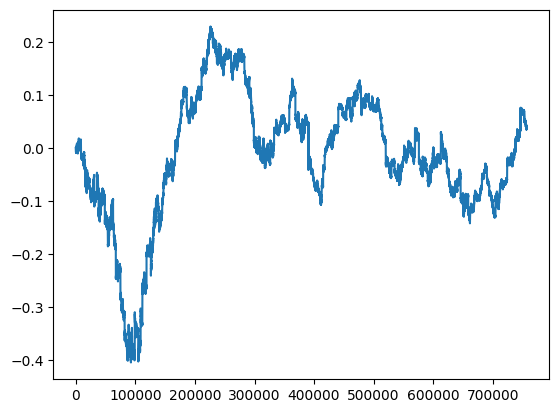

In [20]:
# Compute cumsum of percentage returns
cumsum_percentage_returns = {
  'TSLA': tsla_percentage_returns.cumsum(),
  'MSFT': msft_percentage_returns.cumsum(),
  'AMZN': amzn_percentage_returns.cumsum(),
  'NFLX': nflx_percentage_returns.cumsum(),
  'EBAY': ebay_percentage_returns.cumsum(),
  'APPL': appl_percentage_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_percentage_returns.items()}
tsla_cumsum_percentage_returns = tsla_percentage_returns.cumsum()
x = list(range(1, len(tsla_cumsum_percentage_returns)+1))
plt.plot(x, tsla_cumsum_percentage_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [24]:
# Standard Hurst
method = 'standard'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_std_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_std_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:91: UserWarning: Hurst exponent not in a valid range (0,1).
  warnings.warn("Hurst exponent not in a valid range (0,1).")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0006349...",1,1.0,0.031746,-6328.672852,0.728030,0.999256,0.511026,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001783...",1,1.0,0.022222,-7181.127772,0.655096,0.999260,0.495812,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003985...",1,1.0,0.028571,-6799.876129,0.597722,0.999590,0.513942,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003739...",1,1.0,0.022222,-6483.778489,1.008545,0.998578,0.502694,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0005491...",1,1.0,0.022222,-6767.817705,0.445798,0.999733,0.503846,EBAY,percentage_returns


In [25]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = percentage_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.40572397843611824


In [26]:
display(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'percentage_returns'), ('MSFT', 'standard', 'percentage_returns'), ('AMZN', 'standard', 'percentage_returns'), ('NFLX', 'standard', 'percentage_returns'), ('EBAY', 'standard', 'percentage_returns'), ('APPL', 'standard', 'percentage_returns')])

#### Generalized Hurst

In [18]:
# Generalized Hurst
method = 'generalized'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_gen_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_gen_hurst_fit_results.head(10))

NameError: name 'cumsum_percentage_returns' is not defined

In [28]:
# Generalized Hurst statistic across stocks
min_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = percentage_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.003373882065829817
Max Generalized Hurst: 0.6037543969957271
Average Generalized Hurst: 0.47981729276702634
Standard_dev Generalized Hurst: 0.23459769266933986


In [30]:
print(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'percentage_returns'), ('MSFT', 'generalized', 'percentage_returns'), ('AMZN', 'generalized', 'percentage_returns'), ('NFLX', 'generalized', 'percentage_returns'), ('EBAY', 'generalized', 'percentage_returns'), ('APPL', 'generalized', 'percentage_returns')])


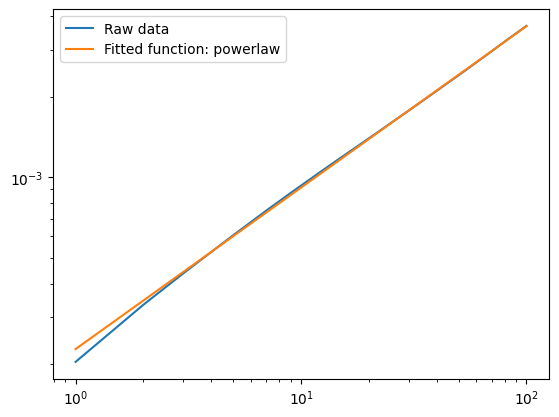

In [31]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = percentage_returns_fit_objects[('TSLA', 'generalized', 'percentage_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Log Returns

In [5]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df)['log_returns']
msft_log_returns = compute_returns(msft_raw_df)['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df)['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df)['log_returns']
appl_log_returns = compute_returns(appl_raw_df)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### Stationarity Test

In [ ]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 3.1. Log returns ACF

In [6]:
# Linear ACF
log_returns_linear_acf_filename = f"{acf_data_dir}/mo_log_returns_linear_acfs.pkl"
log_returns_linear_acfs = compute_acfs(filename=log_returns_linear_acf_filename, data=log_returns, option='linear')
print(log_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [7]:
# Nonlinear ACF
log_returns_nonlinear_acf_filename = f"{acf_data_dir}/mo_log_returns_nonlinear_acfs.pkl"
log_returns_nonlinear_acfs = compute_acfs(filename=log_returns_nonlinear_acf_filename, data=log_returns, option='nonlinear')
print(log_returns_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


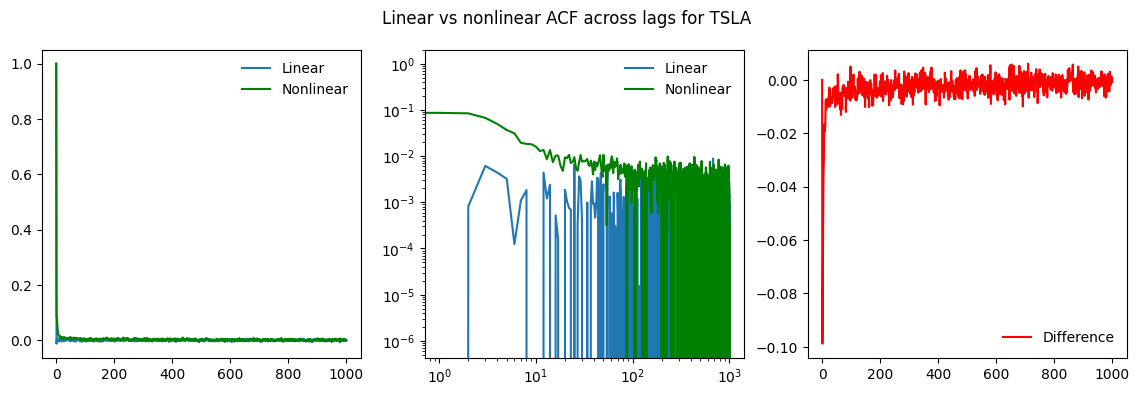

TSLA Max difference: 0.006048815138140205


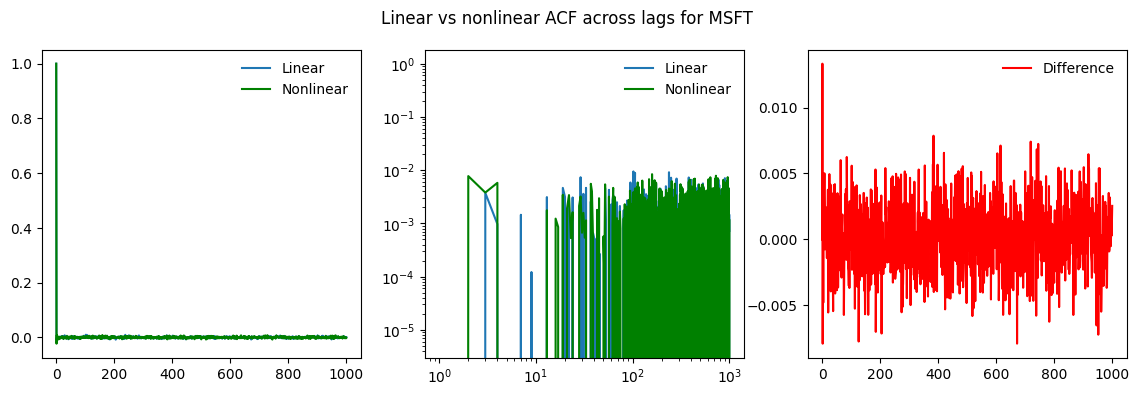

MSFT Max difference: 0.013326040003725557


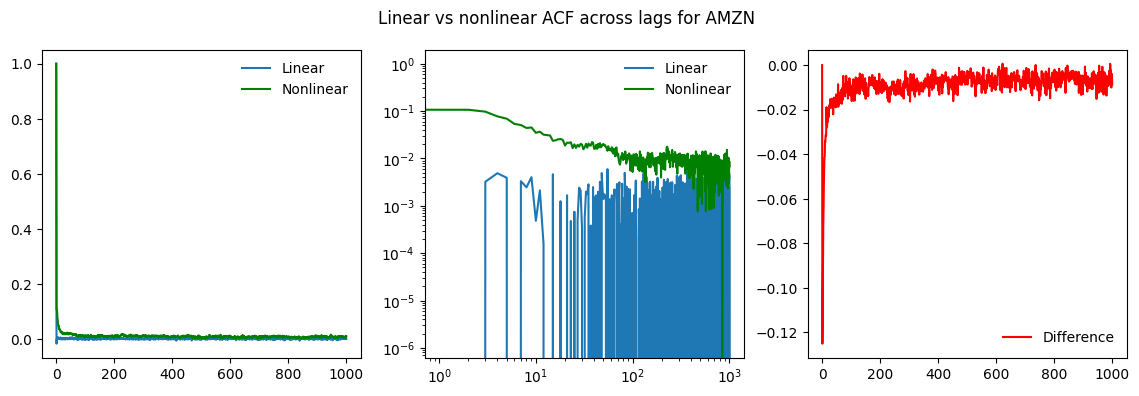

AMZN Max difference: 0.0006590573126442221


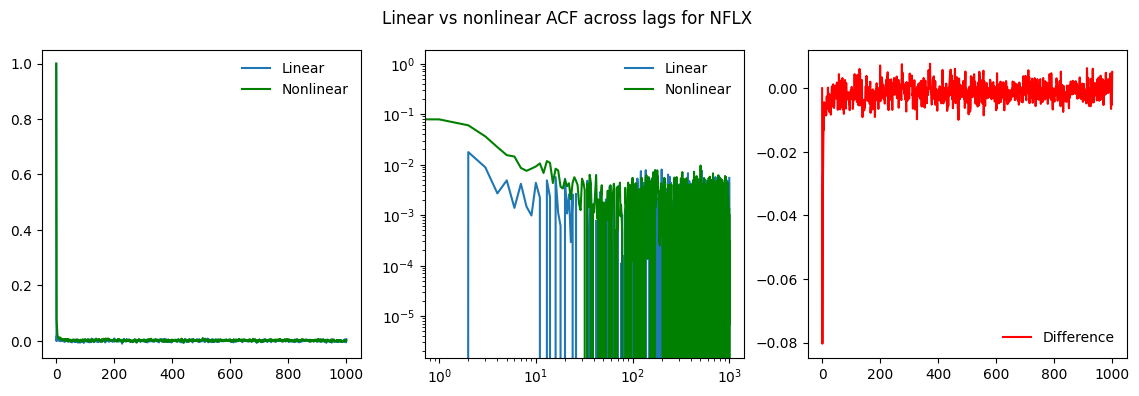

NFLX Max difference: 0.007701335252954775


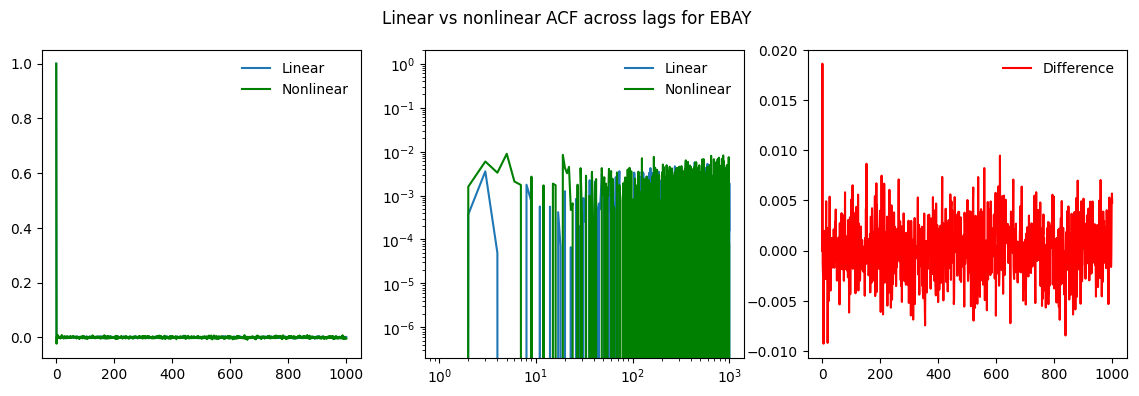

EBAY Max difference: 0.01860772681364388


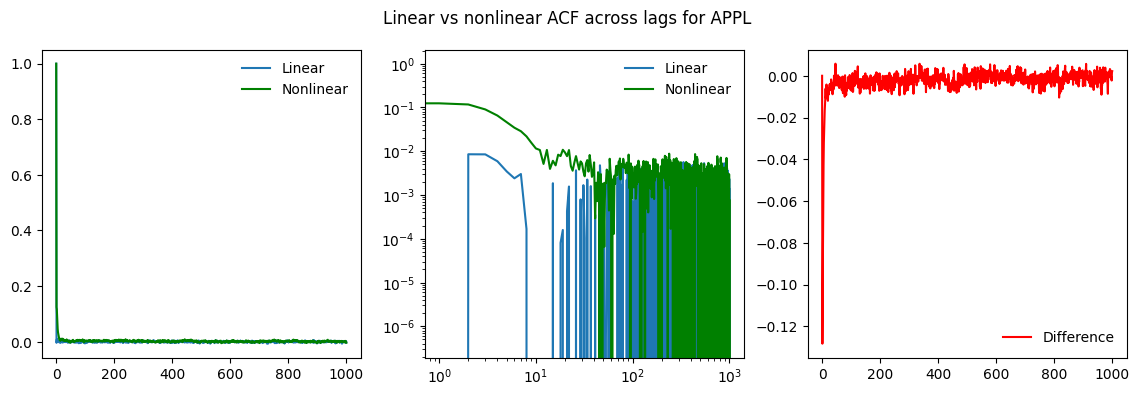

APPL Max difference: 0.0057926980565730195


In [8]:
for stock_name in log_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, log_returns_linear_acfs, log_returns_nonlinear_acfs)

### 3.2. Fit power law to log retrurns ACF

In [37]:
# Load the pre-computed ACFs
log_returns_acf_values = {}

for stock, data in log_returns_nonlinear_acfs.items():
    log_returns_acf_values[stock] = construct_xy(data, stock)

In [38]:
# Using log_returns_nonlinear_acfs
log_returns_fit_results_list = []
log_returns_fit_objects = {}  # Dictionary to store fit objects

for stock, data in log_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[stock] = fit_obj  # Store the fit object

log_returns_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_fit_results.head(10))

cannot unpack non-iterable NoneType object


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1768685...",2,3.0,0.325325,-11817.369666,196.642059,0.701988,-0.848878,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -1.209131...",965,966.0,0.500000,-433.431476,130.688093,-0.093428,0.758854,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0892938...",5,6.0,0.183735,-11582.391670,36.906408,0.673261,-0.411163,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0409077...",4,5.0,0.362086,-11984.093924,228.845255,0.180256,-0.647416,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -5.803460...",355,356.0,0.473684,-7568.196883,298.806675,-0.002573,1.650562,EBAY


In [39]:
log_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [40]:
avg_alpha = log_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.027540994801781127


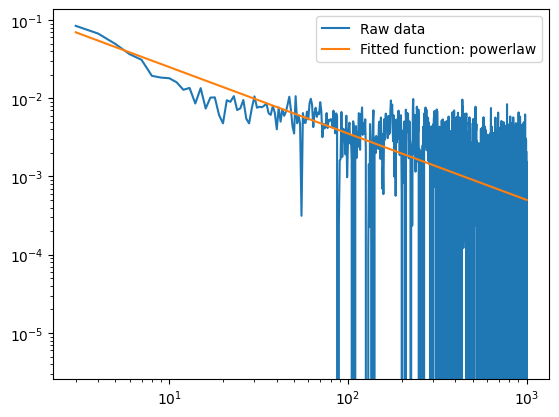

In [41]:
tsla_acf_fit = log_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Log returns Hurst Exponents

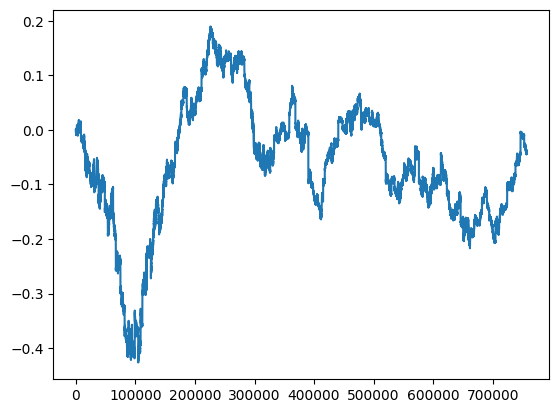

In [9]:
cumsum_log_returns = {
  'TSLA': tsla_log_returns.cumsum(),
  'MSFT': msft_log_returns.cumsum(),
  'AMZN': amzn_log_returns.cumsum(),
  'NFLX': nflx_log_returns.cumsum(),
  'EBAY': ebay_log_returns.cumsum(),
  'APPL': appl_log_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_log_returns.items()}
tsla_cumsum_log_returns = compute_returns(tsla_raw_df)['log_returns'].cumsum()
x = list(range(1, len(tsla_cumsum_log_returns)+1))
plt.plot(x, tsla_cumsum_log_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [11]:
# Standard Hurst
method = 'standard'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_std_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_std_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:39: UserWarning: Time series contained NaN or Inf values. These values were removed.
  return Fit(xy_values, xmin_distance="BIC")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:39: UserWarning: Time series contained NaN or Inf values. These values were removed.
  return Fit(xy_values, xmin_distance="BIC")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:39: UserWarning: Time series contained NaN or Inf values. These values were removed.
  return Fit(xy_values, xmin_distance="BIC")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:39: UserWarning: Time series contained NaN or Inf values. These values were removed.
  return Fit(xy_values, xmin_distance="BIC")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:39: UserWarning: Time series contained NaN or Inf values. These values were removed.
  ret

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0006340...",1,1.0,0.031746,-6346.846606,0.696389,0.999297,0.511184,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001786...",1,1.0,0.022222,-7224.392259,0.617174,0.999354,0.495402,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004041...",1,1.0,0.022222,-6799.741437,0.582184,0.999602,0.514114,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003765...",1,1.0,0.041270,-6472.295117,1.060535,0.998538,0.502250,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0005768...",1,1.0,0.022222,-6765.123532,0.430371,0.999755,0.503607,EBAY,log_returns


In [12]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = log_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.5030648937886234


In [13]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'log_returns'), ('MSFT', 'standard', 'log_returns'), ('AMZN', 'standard', 'log_returns'), ('NFLX', 'standard', 'log_returns'), ('EBAY', 'standard', 'log_returns'), ('APPL', 'standard', 'log_returns')])

#### Generalized Hurst

In [14]:
# Generalized Hurst
method = 'generalized'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_gen_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  mean = np.mean(series)
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  mean = np.mean(series)
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  mean = np.mean(series)
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  mean = np.mean(series)
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  mean = np.mean(series)
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002274...",1,1.0,0.012698,-7322.252260,0.566464,0.999908,0.603960,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.6809912...",1,1.0,0.012698,-8061.554216,0.531582,0.999881,0.538929,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001408...",8,3.0,0.012987,-7646.324152,0.390186,0.999938,0.590590,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001765...",1,1.0,0.019048,-7434.516345,0.738578,0.999827,0.557316,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001552...",1,1.0,0.012698,-7837.892290,0.382726,0.999954,0.587084,EBAY,log_returns


In [15]:
# Generalized Hurst statistic across stocks
min_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = log_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5389294643670957
Max Generalized Hurst: 0.6039596862965453
Average Generalized Hurst: 0.573081238077614
Standard_dev Generalized Hurst: 0.024603277733660302


In [16]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'log_returns'), ('MSFT', 'generalized', 'log_returns'), ('AMZN', 'generalized', 'log_returns'), ('NFLX', 'generalized', 'log_returns'), ('EBAY', 'generalized', 'log_returns'), ('APPL', 'generalized', 'log_returns')])

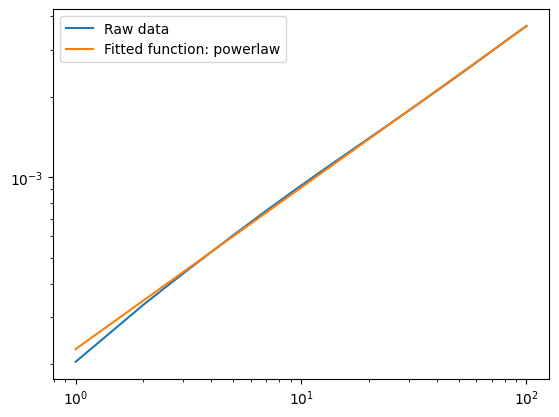

In [17]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = log_returns_fit_objects[('TSLA', 'generalized', 'log_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Return magnitudes

In [19]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

### Stationarity Test

In [19]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

### 4.1. Return magnitude ACF

In [20]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/mo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
display(volatility_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [21]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/mo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
display(volatility_nonlinear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

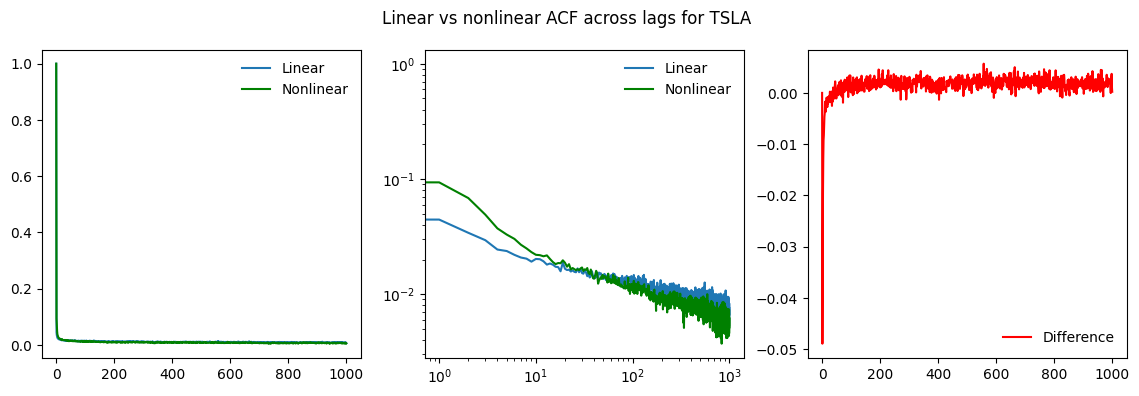

TSLA Max difference: 0.005706750712218543


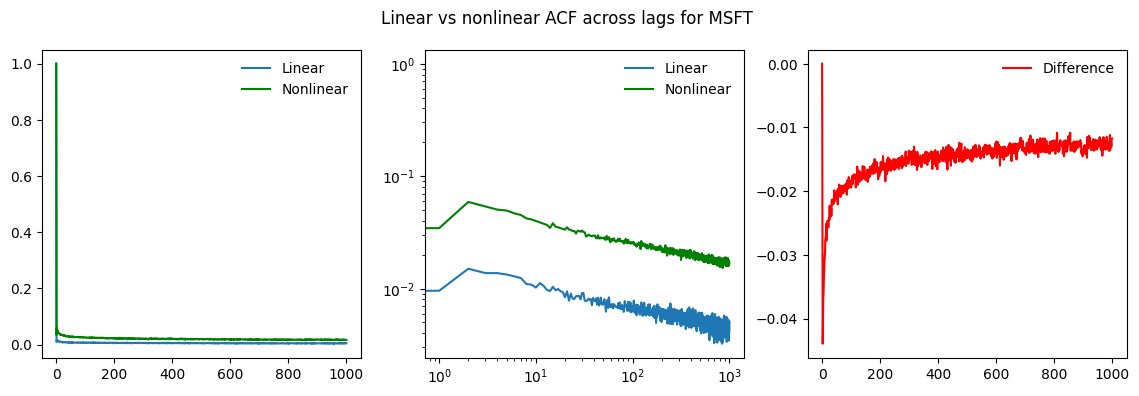

MSFT Max difference: 1.1102230246251565e-16


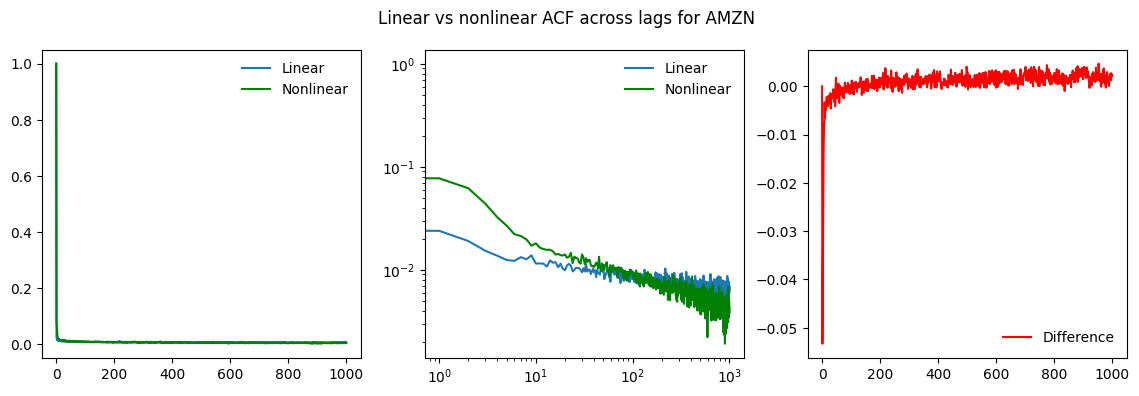

AMZN Max difference: 0.004695065724526252


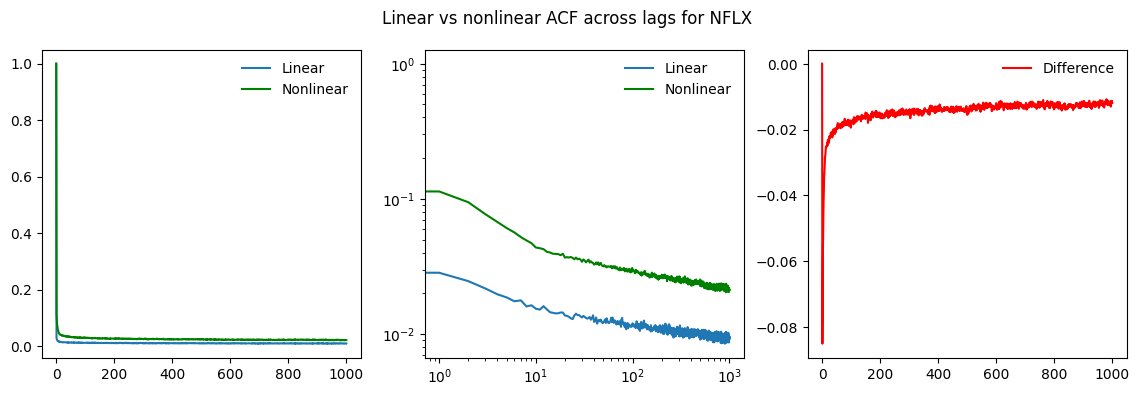

NFLX Max difference: 0.0


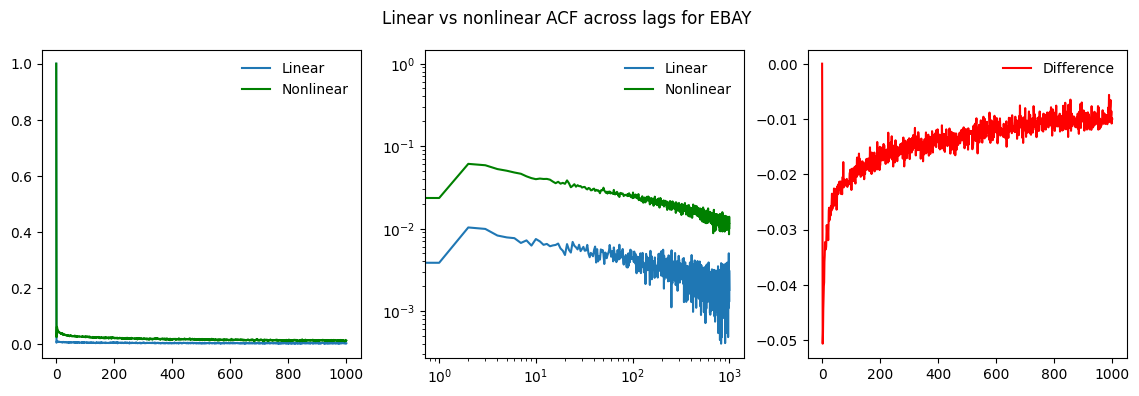

EBAY Max difference: 1.1102230246251565e-16


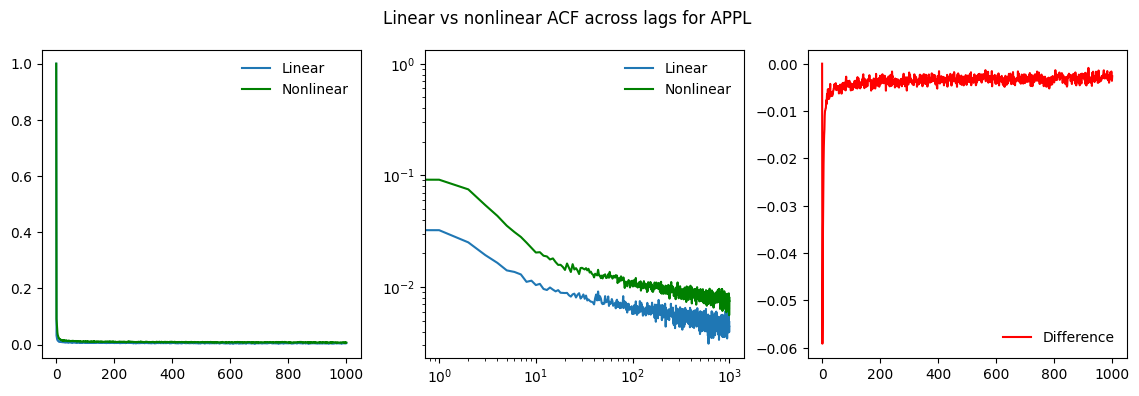

APPL Max difference: 0.0


In [22]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 4.2. Fit power law to ACF

In [23]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [24]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0469176...",4,5.0,0.124373,-13816.385521,9.803333,0.901515,-0.299654,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0611851...",3,4.0,0.053106,-14054.993950,3.152123,0.959010,-0.187905,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0441012...",3,4.0,0.128257,-13747.088683,11.866032,0.872422,-0.344441,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0574695...",9,10.0,0.044355,-14430.813882,2.152771,0.961681,-0.144089,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1416698...",171,172.0,0.114458,-11060.519029,7.067004,0.819213,-0.361047,EBAY


In [25]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.2550737429939604


In [26]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

### 4.3.Volatility Hurst Exponents

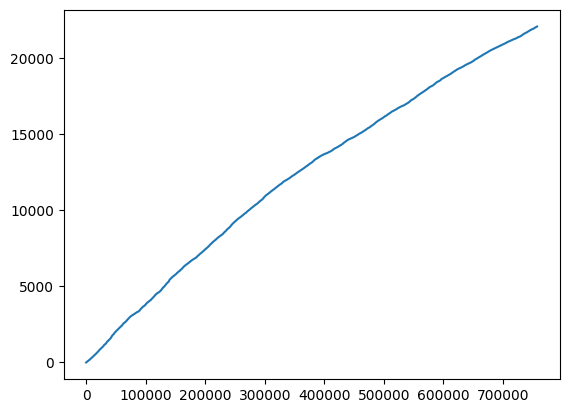

In [27]:
# Return magnitude (volatility)
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

cumsum_return_magnitudes = {
  'TSLA': abs(tsla_returns).cumsum(),
  'MSFT': abs(msft_returns).cumsum(),
  'AMZN': abs(amzn_returns).cumsum(),
  'NFLX': abs(nflx_returns).cumsum(),
  'EBAY': abs(ebay_returns).cumsum(),
  'APPL': abs(appl_returns).cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = abs(tsla_returns).cumsum()
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [28]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0824309...",1,1.0,0.028571,-2628.025947,2.160171,0.998722,0.652420,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0067538...",1,1.0,0.031746,-4363.567443,1.798768,0.998819,0.610723,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1940143...",1,1.0,0.022222,-2351.461492,1.626503,0.999132,0.608692,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0286313...",1,1.0,0.038095,-3445.049236,1.781890,0.999087,0.638202,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0119605...",1,1.0,0.022222,-4350.221078,1.199580,0.999365,0.564645,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0624692...",1,1.0,0.041270,-3214.185586,1.205521,0.999134,0.563613,APPL,volatility


In [29]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6063824344582806


#### Generalized Hurst

In [50]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0380912...",1,1.0,0.012698,-6454.760048,0.001761,1.0,1.000082,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0039680...",1,1.0,0.012698,-8071.721128,0.001563,1.0,1.000027,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0678279...",1,1.0,0.012698,-6326.274568,0.003021,1.0,1.000097,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0168273...",1,1.0,0.012698,-6891.911528,0.004937,1.0,1.000147,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0035609...",1,1.0,0.012698,-8008.952659,0.002884,1.0,1.000038,EBAY,volatility


In [51]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9998595910443213
Max Generalized Hurst: 1.0001466466050912
Average Generalized Hurst: 1.0000419007165708
Standard_dev Generalized Hurst: 9.915132076906352e-05


In [52]:
print(volatility_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volatility'), ('MSFT', 'generalized', 'volatility'), ('AMZN', 'generalized', 'volatility'), ('NFLX', 'generalized', 'volatility'), ('EBAY', 'generalized', 'volatility'), ('APPL', 'generalized', 'volatility')])


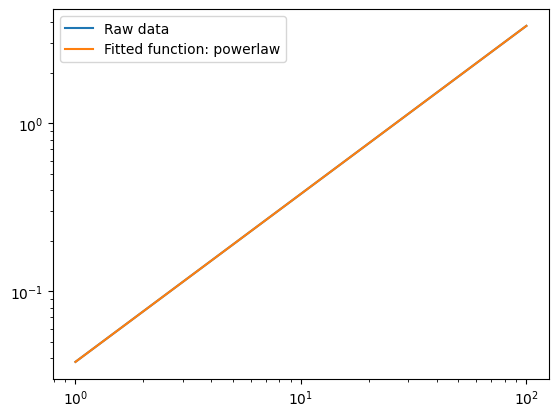

In [53]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volatility_fit_objects[('TSLA', 'generalized', 'volatility')]
tsla_generalized_fit.powerlaw.plot_fit()